In [1]:
import impaintingLib as imp
import re

from torch.utils.tensorboard import SummaryWriter
import torch 

matcher = r"model=(\S+) +loss=(\S+,{0,1})+"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trainloader, testloader = imp.data.getFaces(shuffle=False)
alterFunc = imp.mask.Alter(min_cut=4, max_cut=60, seed=0).squareMask

torch.manual_seed(0)

def modelMatch(model):
    
    if "autoenco" in model :
        res = imp.model.AutoEncoder().to(device)
    elif "unet" in model :
        res = imp.model.UNet().to(device)
    elif "partial" in model :
        res = imp.model.UNetPartialConv().to(device)
    elif "subpix" in model :
        res = imp.model.SubPixelNetwork().to(device)
        
    return res

def lossMatch(loss):
    
    if "l1" in loss :
        res = torch.nn.L1Loss()
    elif "l2" in loss :
        res = torch.nn.L2Loss()
    elif "percep" in loss :
        res = imp.loss.perceptual_loss
    elif "totalvar" in loss :
        res = imp.loss.totalVariationLoss
        
    return res

def parse(expeName = 'basic'):

    count = 0
    path = "./routines/" + expeName + ".txt"
    
    with open(path) as file:
        lines = file.readlines()

    for i,line in enumerate(lines):
        line = line.strip()

        # 1ere ligne = epoch
        if i < 1 :
            epoch = int(line)

        # autres lignes = scenario
        elif line :
            model,losses = re.search(matcher, line).groups()
            losses = losses.split(",")
            losses = [x.capitalize() for x in losses]
            runName = "{} {}".format(model.capitalize()," + ".join(losses))
            
            print("------ Scénario {} : {}".format(count,runName))
            count += 1

            criterions = []
            for loss in losses :
                criterions.append(lossMatch(loss.lower()))
            model = modelMatch(model.lower())
            optimizer  = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
            
            # Train
            print("- Train")
            visu      = imp.utils.Visu(runName = runName, expeName=expeName)
            visuFuncs = [visu.board_loss_train]
            
            imp.process.train(model, optimizer, trainloader, criterions, epochs=epoch, alter=alterFunc, visuFuncs=visuFuncs)
            # imp.process.model_save(model,runName)
            
            # Test
            print("- Test")
            visu      = imp.utils.Visu(runName = runName, expeName=expeName)
            visuFuncs = [visu.board_loss_test,
                         visu.board_plot_last_img,
                         visu.plot_last_img]
            visuFunc  = imp.utils.Visu(runName = runName).board_plot_last_img
            imp.process.test(model, testloader, alter=alterFunc, visuFuncs=visuFuncs)

------ Scénario 0 : Unet L1 + Perceptual
- Train


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

- Test


  0%|          | 0/39 [00:00<?, ?it/s]

------ Scénario 1 : Unetpartial L1 + Perceptual
- Train


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

- Test


  0%|          | 0/39 [00:00<?, ?it/s]

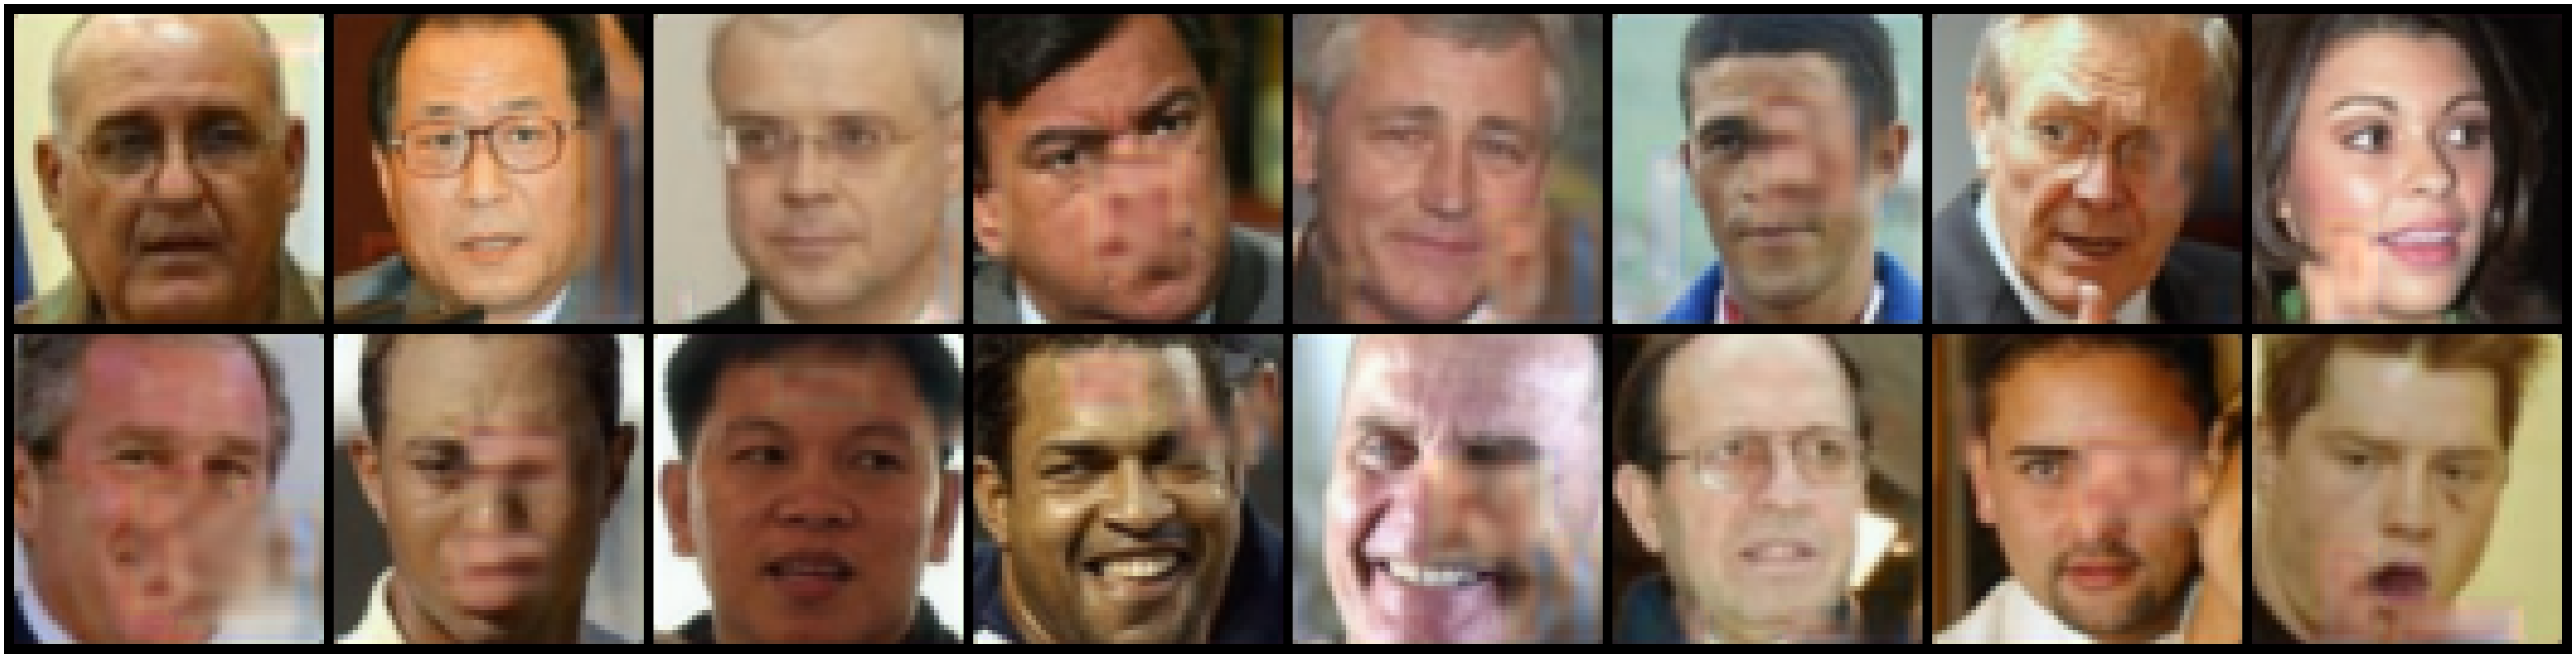

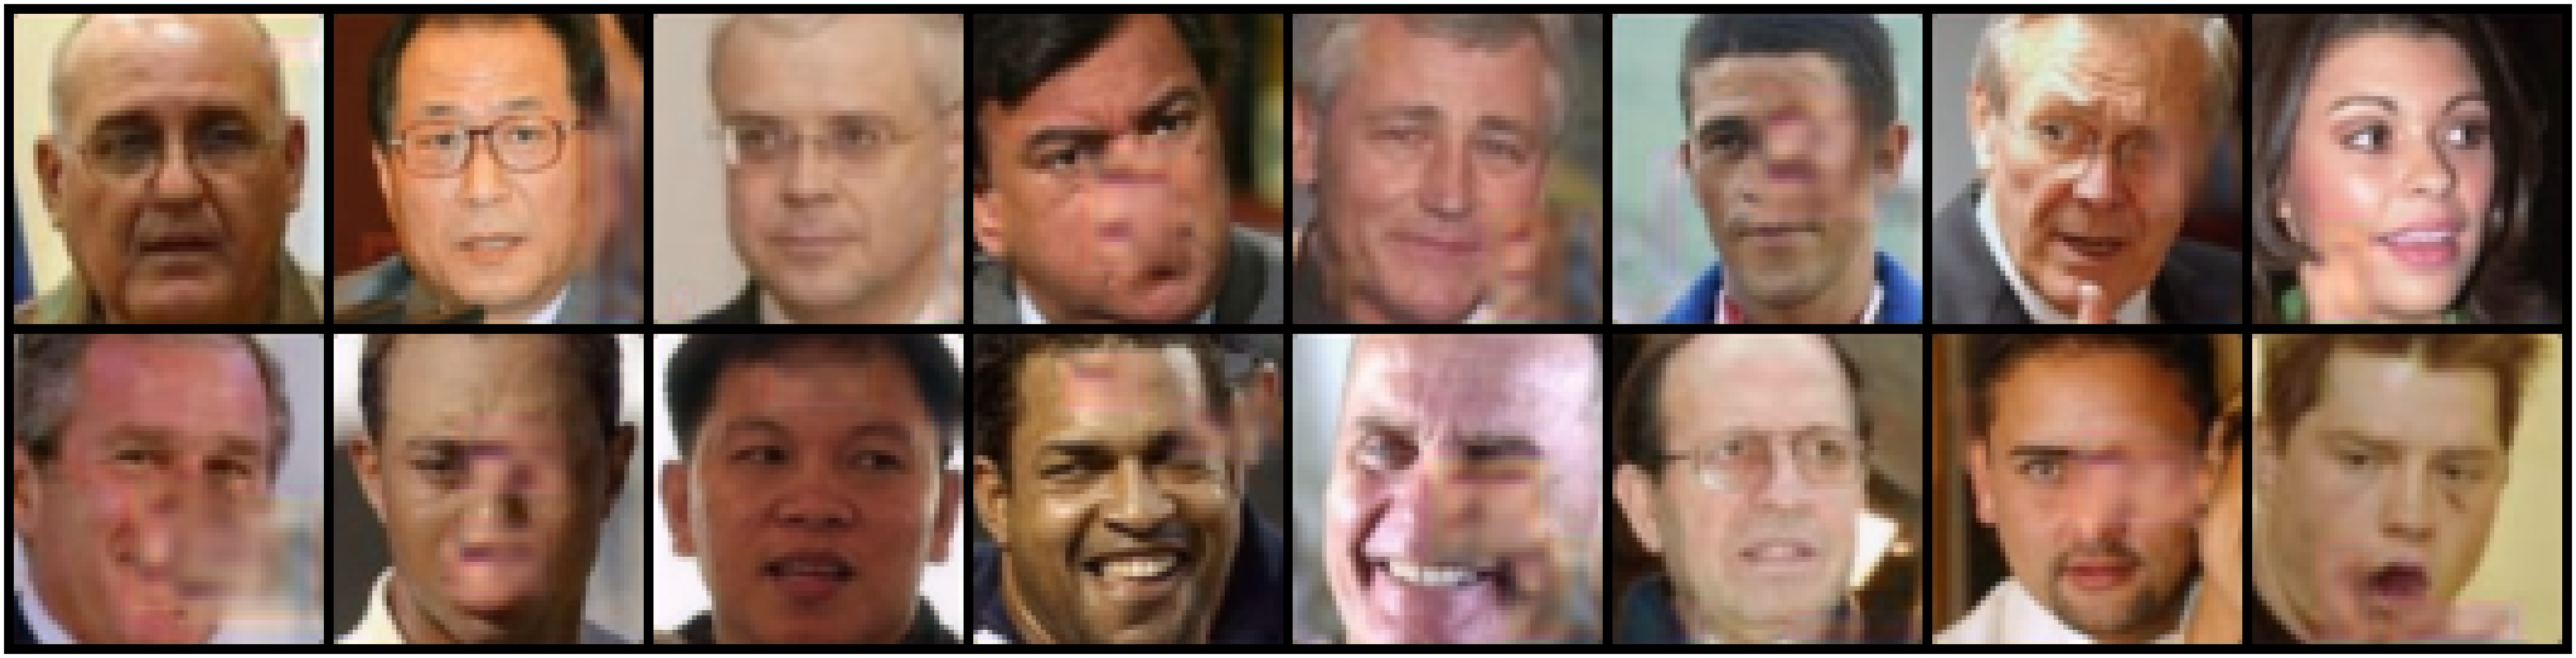

In [2]:
parse("basic2")